# Smile detection: Bewertete Aufgabe PVA5
Die Aufgabe besteht darin in einem real-time Videostream, in einem zu detektierenden Gesicht ein Lächeln festzustellen.

Das Gesicht soll im Video mit einem Rahmen umgeben werden, der mit dem Label "Lächeln" oder "Nicht-Lächeln" bezeichnet ist.

## Teil 1: Training des Smile-Detectors

- Verwendung des SMILES Datensatzes zum Training
- Training unter Verwendung von Transfer Learning (LeNet, VGG, etc.) mit Nachtraining auf dem SMILES Datensatz
- ACHTUNG: SMILES Bilder müssen auf Grauwertbilder mit der dem vortrainierten Netz entsprechender Dimension transformiert werden.


## Teil 2: Deployment auf Videostream

- VideoCapture mit OpenCV (camera = cv2.VideoCapture() - entweder WebCam oder vorbereitetes Video)
- Schleife über die Frames  - while True: (grabbed, frame) = camera.read()
- Verwendung des Face Detektors von OpenCV (facedetector = cv2.CascadeClassifier())
- Der Detektor gibt eine Liste von BoundingBox-Koordinaten mit (facedetector.detectMultiScale(...))
- Extraktion des Region of Interests (roi) aus dem Videoframe und Klassifikation mit unserem Netz (model.predict(roi)[0])
- Ausgabe mit Label (cv2.putText und cv2.rectangle und cv2.imshow("Face", frameClone)

## Download Smile images and prepare training, validation and test data

We download the images from gitub and divide them into a training and test folder. We also minimize the training set to have a balanced dataset with the two labels `positive_smiles` and `negative_smiles`. So we can prevent imbalanced data which can bias our model when we train the classifier on our data.

In [98]:
!curl -LO https://github.com/hromi/SMILEsmileD/archive/refs/heads/master.zip && \
unzip -q master.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   133  100   133    0     0    715      0 --:--:-- --:--:-- --:--:--   715
100 39.6M    0 39.6M    0     0  14.3M      0 --:--:--  0:00:02 --:--:-- 16.1M


In [99]:
!ls && \
ls -l SMILEsmileD-master/SMILEs && \
pushd SMILEsmileD-master/SMILEs && \
mv ./positives ./positive_smiles && \
mv ./negatives ./negative_smiles && \
popd && \
mkdir -p SMILEsmileD-master/test/positive_smiles SMILEsmileD-master/test/negative_smiles && \
mkdir -p SMILEsmileD-master/training/positive_smiles SMILEsmileD-master/training/negative_smiles && \
ls -l SMILEsmileD-master/SMILEs

SMILEsmileD-master  smilde_detection_model
master.zip	    smile_detection_pva5.ipynb
total 8
drwxrwxr-x 3 dana_shmaria dana_shmaria 4096 Oct 28  2010 negatives
drwxrwxr-x 3 dana_shmaria dana_shmaria 4096 Oct 28  2010 positives
~/Documents/DeepMoji-init-model/CodingKatas/SMILEsmileD-master/SMILEs ~/Documents/DeepMoji-init-model/CodingKatas
~/Documents/DeepMoji-init-model/CodingKatas
total 8
drwxrwxr-x 3 dana_shmaria dana_shmaria 4096 Oct 28  2010 negative_smiles
drwxrwxr-x 3 dana_shmaria dana_shmaria 4096 Oct 28  2010 positive_smiles


In [100]:
import pathlib
import os

data_dir = pathlib.Path('./SMILEsmileD-master/SMILEs')

positive_smiles = list(data_dir.glob('positive_smiles/*/*.jpg'))
negative_smiles = list(data_dir.glob('negative_smiles/*/*.jpg'))

training_size = 3000
test_size = 50

print('We have {} positive smiles and {} negative smils'.format(len(positive_smiles), len(negative_smiles)))

print(f'Selecting {training_size} images for training each (positive and negative) to not have any imbalanced data')
for i, path in enumerate(positive_smiles[:training_size]):
    path.rename('./SMILEsmileD-master/training/positive_smiles/pos_test_{}.jpg'.format(i + 1))

for i, path in enumerate(negative_smiles[:training_size]):
    path.rename('./SMILEsmileD-master/training/negative_smiles/neg_test_{}.jpg'.format(i + 1))
    
    
print(f'Selecting {test_size} test images each')
for i, path in enumerate(positive_smiles[training_size:training_size + test_size]):
    path.rename('./SMILEsmileD-master/test/positive_smiles/pos_test_{}.jpg'.format(i + 1))

for i, path in enumerate(negative_smiles[training_size:training_size + test_size]):
    path.rename('./SMILEsmileD-master/test/negative_smiles/neg_test_{}.jpg'.format(i + 1))

We have 3690 positive smiles and 9475 negative smils
Selecting 3000 images for training each (positive and negative) to not have any imbalanced data
Selecting 50 test images each


In [101]:
import tensorflow as tf

training_dir = pathlib.Path('./SMILEsmileD-master/training')
print(len(list(training_dir.glob('**/*.jpg'))))

image_width = image_height = 64
batch_size = 32

training_set = tf.keras.preprocessing.image_dataset_from_directory(
  training_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size
)

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
  training_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size
)

class_names = training_set.class_names
print('Labels: ', training_set.class_names)

6000
Found 6000 files belonging to 2 classes.
Using 4800 files for training.
Found 6000 files belonging to 2 classes.
Using 1200 files for validation.
Labels:  ['negative_smiles', 'positive_smiles']


## Build up transfer learning model

We will use the VGG19 as our base model, freeze the layers of the base model and use the global average pooling approach to create our binary classifier. At the end we save the model, so we can load it into our python application for the smile detection on the video stream.

In [102]:
from tensorflow.keras import layers, Model, Input, applications
from tensorflow.keras.models import Sequential

input_shape = (64, 64, 3)

base_model = applications.VGG19(include_top=False, weights='imagenet', input_shape=input_shape)        
base_model.trainable = False

inputs = Input(shape=input_shape)
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

In [103]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 64, 64, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(training_set, epochs=40, validation_data=validation_set)

Epoch 1/40
150/150 [==============================] - 34s 221ms/step - loss: 0.4919 - binary_accuracy: 0.7811 - val_loss: 0.5167 - val_binary_accuracy: 0.7550
Epoch 2/40
150/150 [==============================] - 33s 221ms/step - loss: 0.4902 - binary_accuracy: 0.7745 - val_loss: 0.5114 - val_binary_accuracy: 0.7567
Epoch 3/40
150/150 [==============================] - 33s 220ms/step - loss: 0.4845 - binary_accuracy: 0.7792 - val_loss: 0.5092 - val_binary_accuracy: 0.7608
Epoch 4/40
150/150 [==============================] - 33s 220ms/step - loss: 0.4819 - binary_accuracy: 0.7816 - val_loss: 0.5094 - val_binary_accuracy: 0.7583
Epoch 5/40
150/150 [==============================] - 33s 221ms/step - loss: 0.4826 - binary_accuracy: 0.7829 - val_loss: 0.5039 - val_binary_accuracy: 0.7708
Epoch 6/40
150/150 [==============================] - 33s 218ms/step - loss: 0.4783 - binary_accuracy: 0.7898 - val_loss: 0.5037 - val_binary_accuracy: 0.7658
Epoch 7/40
150/150 [==========================

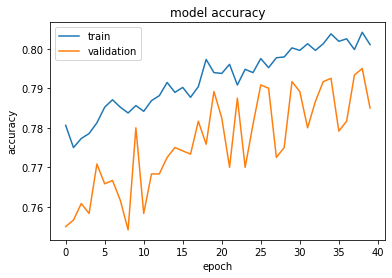

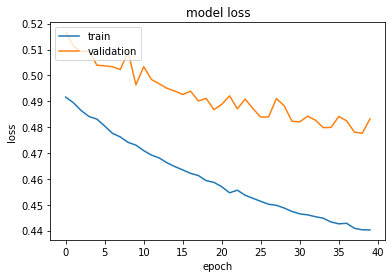

In [112]:
# plot accuracy and loss over training and validation data
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Model performance
The model performance be shown throught the learning curves. We reach a high accuracy with training and validation data (over 75%) which is good for this complex task of detecting smiles. Even for humans it is not that easy and we also sometimes were not sure if the person on the image is smiling or not. The model loss is with 45 to 50% still very high.

What could be improved:
- instead of freezing the whole base model, we could retrain some layers to increase the model performance. But then we also need to be careful to not overfit the model.
- The loss of the model can be improved with training for more epochs, but it does not really decrease that much anymore.

In [125]:
model.save('smile_detection_model')

INFO:tensorflow:Assets written to: smile_detection_model/assets


## Testing model

In [113]:
test_dir = pathlib.Path('./SMILEsmileD-master/test')
print(len(list(test_dir.glob('**/*.jpg'))))

100


In [114]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(image_height, image_width)
)

Found 100 files belonging to 2 classes.


In [123]:
predictions = model.predict(test_set)
model.evaluate(test_set)

4/4 [==============================] - 1s 150ms/step - loss: 0.4915 - binary_accuracy: 0.8100


[0.4914693534374237, 0.8100000023841858]

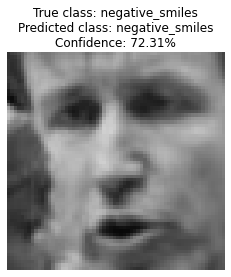

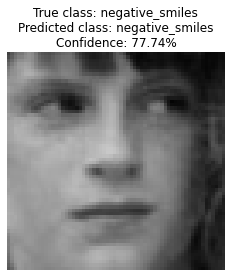

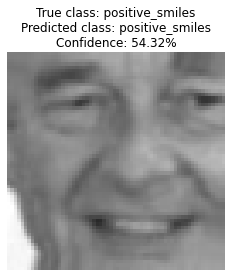

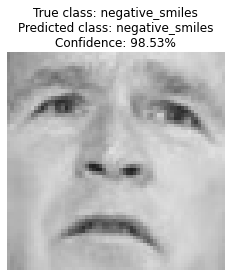

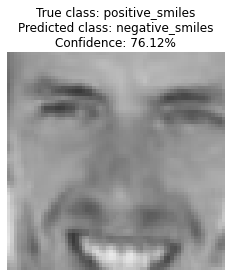

In [121]:
import matplotlib.pyplot as plt
import numpy as np
for images, labels in test_set.take(1):
    for i in range(5):
        predictions = model.predict(tf.expand_dims(images[i], 0))
        predicted_label = 1 if predictions[0][0] > 0.5 else 0
        if predicted_label == 1:
            confidence = predictions[0][0] * 100
        else:
            confidence = (1-predictions[0][0]) * 100
        plt.figure()
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(
            "True class: {}\nPredicted class: {}\nConfidence: {:.2f}%"
            .format(class_names[labels[i]], class_names[predicted_label], confidence)
        )
        plt.axis("off")
    plt.show()